In [ ]:
# --- Colab: Setup ---
!pip -q install pandas numpy scikit-learn scipy openpyxl

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import re
from scipy import stats

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

import sqlite3
import json


In [ ]:
def clean_cols(df):
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]
    return df

hosp = pd.read_csv("/content/Hospitalisation details.csv")
med = pd.read_csv("/content/Medical Examinations.csv")
names = pd.read_excel("/content/Names.xlsx")

hosp = clean_cols(hosp)
med = clean_cols(med)
names = clean_cols(names)

# Ensure Customer_ID exists in all three
for df_var in (hosp, med, names):
    if "Customer_ID" not in df_var.columns:
        alt = [c for c in df_var.columns if c.lower().replace("_","") == "customerid"]
        if alt:
            df_var.rename(columns={alt[0]:"Customer_ID"}, inplace=True)

# Merge: Hospitalisation = base
df = hosp.merge(med, on="Customer_ID", how="left", suffixes=("", "_med"))
df = df.merge(names, on="Customer_ID", how="left", suffixes=("", "_name"))

# Replace trivial placeholders with NaN
trivial_values = {"?", "NA", "na", "n/a", "N/A", "", "null", "NULL"}
df = df.replace({c:list(trivial_values) for c in df.columns}, np.nan)

# Keep rows with charges and drop rows with >50% missing
row_missing_frac = df.isna().mean(axis=1)
before_shape = df.shape
df = df[~df["charges"].isna()]
df = df[row_missing_frac <= 0.5]
after_shape = df.shape

print("Rows before:", before_shape, " after:", after_shape)

Rows before: (2343, 17)  after: (2337, 17)


In [ ]:
# Numeric clean helper
def to_numeric_clean(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float, np.number)): return x
    m = re.search(r"(\d+)", str(x))
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan

if "NumberOfMajorSurgeries" in df.columns:
    df["NumberOfMajorSurgeries"] = df["NumberOfMajorSurgeries"].apply(to_numeric_clean)

# Ensure y/m/d columns are present if available (sometimes caps vary)
for comp in ["year","month","date"]:
    if comp not in df.columns:
        alts = [c for c in df.columns if c.lower()==comp]
        if alts:
            df.rename(columns={alts[0]: comp}, inplace=True)

def safe_int(x):
    try: return int(float(x))
    except: return np.nan

if all(col in df.columns for col in ["year","month","date"]):
    y = df["year"].apply(safe_int)
    m = df["month"].apply(safe_int).fillna(1).clip(1,12)
    d = df["date"].apply(safe_int).fillna(1).clip(1,28)
    dob = pd.to_datetime(dict(year=y, month=m, day=d), errors="coerce")
    df["date_of_birth"] = dob
    today = pd.Timestamp(date.today())
    df["age"] = (today - dob).dt.days / 365.25
else:
    df["age"] = np.nan

# Infer gender from salutation in 'name'
def infer_gender(name):
    if pd.isna(name): return np.nan
    s = re.sub(r"[.,]", "", str(name)).strip().lower()
    first = s.split()[0] if s.split() else ""
    if first in ["mr","sir"]: return "Male"
    if first in ["mrs","ms","miss","madam","madame"]: return "Female"
    return "Unknown"

if "name" in df.columns:
    df["gender"] = df["name"].apply(infer_gender)
else:
    df["gender"] = "Unknown"

# Normalize tiers
for col in ["Hospital_tier", "City_tier"]:
    if col in df.columns:
        df[col] = (df[col].astype(str).str.strip().str.lower()
                   .str.replace("tier 1", "tier-1")
                   .str.replace("tier 2", "tier-2")
                   .str.replace("tier 3", "tier-3"))

# Booleans to 0/1
def to_bool01(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().lower()
    return {"yes":1,"true":1,"y":1,"1":1,"no":0,"false":0,"n":0,"0":0}.get(s, np.nan)

for col in ["smoker","Heart_Issues","Any_Transplants","Cancer_history"]:
    if col in df.columns:
        df[col] = df[col].apply(to_bool01)

# State grouping
if "State_ID" in df.columns:
    df["State_ID"] = df["State_ID"].astype(str).str.strip().str.upper()
    df["State_ID_grouped"] = df["State_ID"].where(df["State_ID"].isin(["R1011","R1012","R1013"]), "Other")

# Coerce HBA1C, children to numeric
if "HBA1C" in df.columns:
    df["HBA1C"] = pd.to_numeric(df["HBA1C"], errors="coerce")
if "children" in df.columns:
    df["children"] = pd.to_numeric(df["children"], errors="coerce")

# If no BMI column exists, create placeholder (kept as NaN—model handles it)
if "BMI" not in df.columns:
    df["BMI"] = np.nan

print("Engineered columns present:", [c for c in ["age","gender","State_ID_grouped","BMI","HBA1C","children","NumberOfMajorSurgeries"] if c in df.columns])


Engineered columns present: ['age', 'gender', 'State_ID_grouped', 'BMI', 'HBA1C', 'children', 'NumberOfMajorSurgeries']


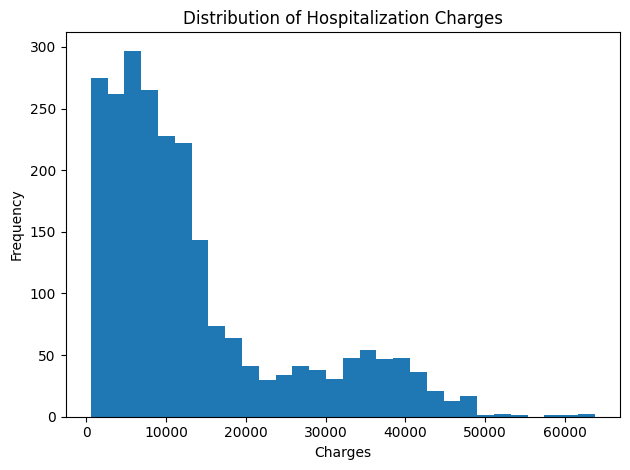

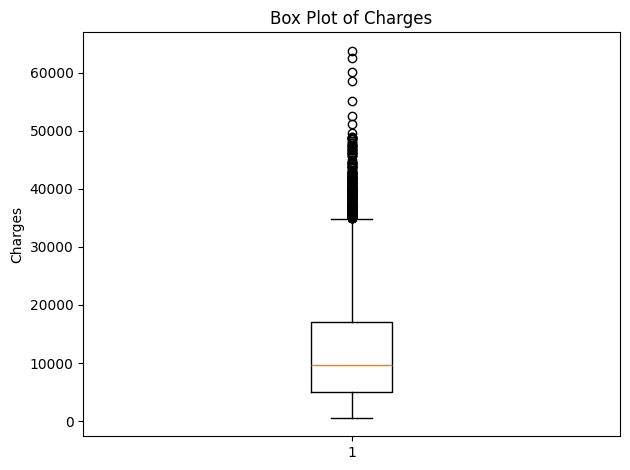

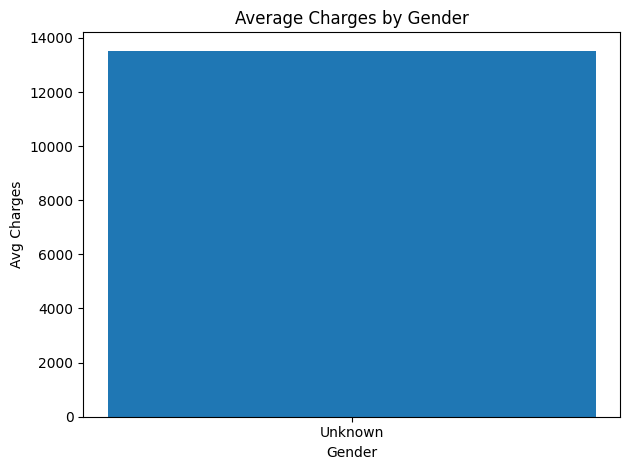

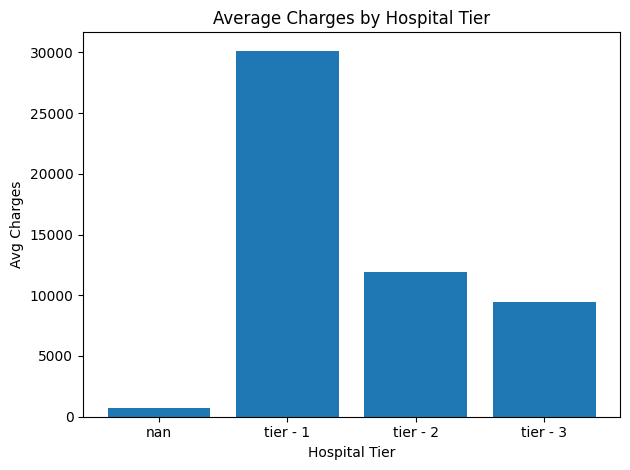

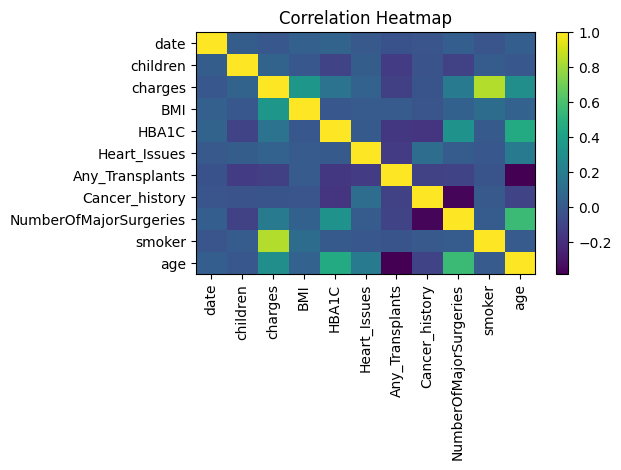

In [ ]:
# Histogram of charges
plt.figure()
df["charges"].plot(kind="hist", bins=30)
plt.title("Distribution of Hospitalization Charges")
plt.xlabel("Charges"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()

# Box plot of charges
plt.figure()
plt.boxplot(df["charges"].dropna())
plt.title("Box Plot of Charges"); plt.ylabel("Charges"); plt.tight_layout(); plt.show()

# Average charges by gender (if available)
if "gender" in df.columns:
    means = df.dropna(subset=["gender","charges"]).groupby("gender")["charges"].mean()
    plt.figure()
    plt.bar(means.index.astype(str), means.values)
    plt.title("Average Charges by Gender"); plt.xlabel("Gender"); plt.ylabel("Avg Charges"); plt.tight_layout(); plt.show()

# Average charges by Hospital tier
if "Hospital_tier" in df.columns:
    means2 = df.dropna(subset=["Hospital_tier","charges"]).groupby("Hospital_tier")["charges"].mean()
    plt.figure()
    plt.bar(means2.index.astype(str), means2.values)
    plt.title("Average Charges by Hospital Tier"); plt.xlabel("Hospital Tier"); plt.ylabel("Avg Charges"); plt.tight_layout(); plt.show()

# Correlation heatmap (numeric only)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()
plt.figure()
plt.imshow(corr, aspect='auto'); plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Heatmap"); plt.tight_layout(); plt.show()


In [ ]:
# ANOVA: charges by Hospital_tier
anova_hosp = None
if "Hospital_tier" in df.columns:
    groups = [g["charges"].dropna().values for _, g in df.groupby("Hospital_tier")]
    if len(groups) >= 2 and all(len(g) > 1 for g in groups):
        anova_hosp = stats.f_oneway(*groups)
        print("ANOVA (Hospital_tier):", anova_hosp)

# ANOVA: charges by City_tier
anova_city = None
if "City_tier" in df.columns:
    groups = [g["charges"].dropna().values for _, g in df.groupby("City_tier")]
    if len(groups) >= 2 and all(len(g) > 1 for g in groups):
        anova_city = stats.f_oneway(*groups)
        print("ANOVA (City_tier):", anova_city)

# Welch t-test: smokers vs non-smokers
ttest_smoker = None
if "smoker" in df.columns:
    smokers = df.loc[df["smoker"]==1, "charges"].dropna()
    nonsmokers = df.loc[df["smoker"]==0, "charges"].dropna()
    if len(smokers) > 1 and len(nonsmokers) > 1:
        ttest_smoker = stats.ttest_ind(smokers, nonsmokers, equal_var=False)
        print("Welch t-test (smoker vs non-smoker):", ttest_smoker)

# Chi-square: smoker vs heart issues
chi2_result = None
if "smoker" in df.columns and "Heart_Issues" in df.columns:
    contingency = pd.crosstab(df["smoker"], df["Heart_Issues"])
    if contingency.values.sum() > 0:
        chi2_result = stats.chi2_contingency(contingency)
        print("\nContingency (smoker vs heart issues):\n", contingency)
        print("Chi-square:", chi2_result)


Welch t-test (smoker vs non-smoker): TtestResult(statistic=np.float64(56.243498518672), pvalue=np.float64(7.430150719163662e-238), df=np.float64(583.7730273541956))

Contingency (smoker vs heart issues):
 Heart_Issues   0.0  1.0
smoker                 
0.0           1110  735
1.0            297  191
Chi-square: Chi2ContingencyResult(statistic=np.float64(0.05210493727554302), pvalue=np.float64(0.8194401862037882), dof=1, expected_freq=array([[1112.69395628,  732.30604372],
       [ 294.30604372,  193.69395628]]))


In [ ]:
# Compact, business-relevant features
feature_list = [c for c in [
    "age","children","BMI","HBA1C","NumberOfMajorSurgeries",
    "smoker","Heart_Issues","Any_Transplants","Cancer_history",
    "Hospital_tier","City_tier","State_ID_grouped","gender"
] if c in df.columns]

X = df[feature_list].copy()
y = df["charges"].values

cat_cols = [c for c in feature_list if X[c].dtype == 'O']
num_cols = [c for c in feature_list if c not in cat_cols]

numeric_tf = Pipeline([("imputer", SimpleImputer(strategy="median")),
                       ("scaler", StandardScaler())])
categorical_tf = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                           ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocess = ColumnTransformer(
    [("num", numeric_tf, num_cols),
     ("cat", categorical_tf, cat_cols)],
    remainder="drop"
)

# Stratified 5-fold on binned target (so regression behaves nicely with CV)
bins = pd.qcut(df["charges"], q=5, duplicates="drop")
bins_codes = pd.factorize(bins)[0]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_splits = list(skf.split(np.zeros(len(y)), bins_codes))

# Ridge CV (manual small alpha grid)
alphas = [0.1, 1.0, 10.0]
best_rmse, best_alpha = np.inf, None

for a in alphas:
    rmses = []
    for train_idx, test_idx in cv_splits:
        Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
        ytr, yte = y[train_idx], y[test_idx]
        pipe = Pipeline([("preprocess", preprocess),
                         ("model", Ridge(alpha=a, random_state=42))])
        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xte)
        rmses.append(np.sqrt(mean_squared_error(yte, pred)))
    avg_rmse = float(np.mean(rmses))
    if avg_rmse < best_rmse:
        best_rmse, best_alpha = avg_rmse, a

ridge_best = Pipeline([("preprocess", preprocess),
                       ("model", Ridge(alpha=best_alpha, random_state=42))])
ridge_best.fit(X, y)

# Gradient Boosting (single config, no CV — fast feature importances)
gbr = Pipeline([("preprocess", preprocess),
                ("model", GradientBoostingRegressor(n_estimators=150, max_depth=3, learning_rate=0.1, random_state=42))])
gbr.fit(X, y)

# Feature importances (from GBR)
preprocess.fit(X)
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"] if cat_cols else None
cat_names = list(ohe.get_feature_names_out(cat_cols)) if cat_cols else []
feature_names = num_cols + cat_names
importances = gbr.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
fi.head(20)


,feature,importance
5,smoker,0.742936
2,BMI,0.113151
0,age,0.095662
10,Hospital_tier_tier - 1,0.016754
1,children,0.007689
18,State_ID_grouped_R1011,0.006822
12,Hospital_tier_tier - 3,0.005959
3,HBA1C,0.004521
20,State_ID_grouped_R1013,0.003458
17,State_ID_grouped_Other,0.001504


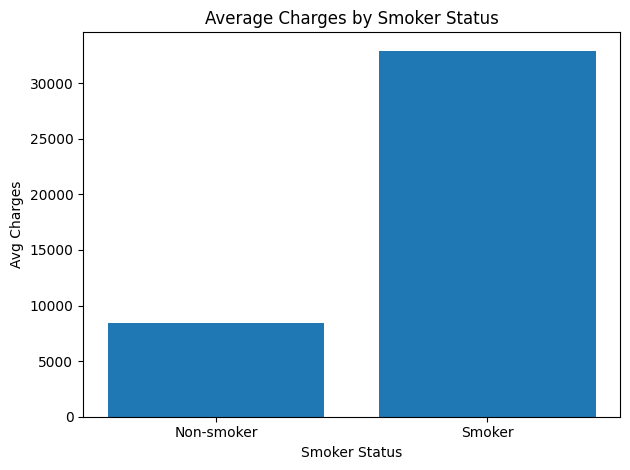

In [ ]:
# Average charges by smoker status
if "smoker" in df.columns:
    smoker_means = df.dropna(subset=["smoker","charges"]).groupby("smoker")["charges"].mean()
    plt.figure()
    plt.bar(smoker_means.index.map({0: "Non-smoker", 1: "Smoker"}), smoker_means.values)
    plt.title("Average Charges by Smoker Status"); plt.xlabel("Smoker Status"); plt.ylabel("Avg Charges"); plt.tight_layout(); plt.show()

In [ ]:
def bmi_from_cm_kg(h_cm, w_kg):
    return w_kg/((h_cm/100.0)**2)

# Build a single-row record with our compact feature set
jayna = {c: np.nan for c in feature_list}
# Age from DOB 1988-12-28:
dob = pd.Timestamp(year=1988, month=12, day=28)
today = pd.Timestamp(date.today())
if "age" in feature_list: jayna["age"] = (today - dob).days/365.25
if "children" in feature_list: jayna["children"] = 2
if "BMI" in feature_list: jayna["BMI"] = bmi_from_cm_kg(170,85)
if "HBA1C" in feature_list: jayna["HBA1C"] = 5.8
if "NumberOfMajorSurgeries" in feature_list: jayna["NumberOfMajorSurgeries"] = 0
if "smoker" in feature_list: jayna["smoker"] = 1
if "Heart_Issues" in feature_list: jayna["Heart_Issues"] = 0
if "Any_Transplants" in feature_list: jayna["Any_Transplants"] = 0
if "Cancer_history" in feature_list: jayna["Cancer_history"] = 1
if "Hospital_tier" in feature_list: jayna["Hospital_tier"] = "tier-1"
if "City_tier" in feature_list: jayna["City_tier"] = "tier-1"
if "State_ID_grouped" in feature_list: jayna["State_ID_grouped"] = "R1011"
if "gender" in feature_list: jayna["gender"] = "Female"

jayna_df = pd.DataFrame([jayna])[feature_list]

ridge_pred = float(ridge_best.predict(jayna_df)[0])
gbr_pred = float(gbr.predict(jayna_df)[0])

print(f"Ridge (alpha={best_alpha}) CV RMSE ≈ {best_rmse:,.2f}")
print("Predicted cost (Ridge):", round(ridge_pred, 2))
print("Predicted cost (GBR)  :", round(gbr_pred, 2))


Ridge (alpha=10.0) CV RMSE ≈ 4,490.90
Predicted cost (Ridge): 29543.27
Predicted cost (GBR)  : 26739.09
